尝试算法：
1.随机能力t1，t2，给难度多个初始值，取其中似然函数最小的为b1，b2
2.由难度b1，b2，给能力多个初始值及t1，t2，取其中似然函数最小的为t1，t2
3.由能力t1，t2，给难度多个初始值及b1，b2，取其中似然函数最小的为b1，b2
4.重复2,3
5.重复1,2,3
结果：
发现似然最小值不一定是误差最小值，误差最小值可能似然函数较大。

In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pymc
import scipy.stats as stats
from scipy.optimize import minimize, rosen, rosen_der

In [178]:
def min_thete(y,w,b1,b2,a):
    start1 = y.shape[0]
    bnds = ((-3, 3), (-3, 3))*(y.shape[0])
    def f(x):
        t1 = np.array(x[:start1]).reshape(y.shape[0],1)
        t2 = np.array(x[start1:]).reshape(y.shape[0],1)
        p1 = (1./(1+ np.exp(-(t1-b1)))).reshape(y.shape)
        p2 = (1./(1+ np.exp(-(t2-b2)))).reshape(y.shape)
        f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())+w*((b1**2).sum())+w*((b2**2).sum())
        ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[:start1])
        ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]+2*w*np.array(x[start1:])
#         f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]
#         ft1 = -((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=1)/y.shape[1]
#         ft2 = -((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=1)/y.shape[1]
        f2 = np.concatenate((ft1,ft2))
        return f1, f2
    res = minimize(f, (a), bounds=bnds,method='L-BFGS-B',jac=True)
    min_t1 = np.array(res.x[:start1]).reshape(y.shape[0],1)
    min_t2 = np.array(res.x[start1:]).reshape(y.shape[0],1)
    return min_t1, min_t2, res.fun

In [179]:
def min_b(y,w,t1,t2,a):
    start1 = y.shape[1]
    bnds = ((-3, 3), (-3, 3))*(y.shape[1])
    def f(x):
        b1 = np.array([[x[:start1]]])
        b2 = np.array([[x[start1:]]])
        p1 = (1./(1+ np.exp(-(t1-b1)))).reshape(y.shape)
        p2 = (1./(1+ np.exp(-(t2-b2)))).reshape(y.shape)
        f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]+w*((np.array([x])**2).sum())+w*((t1**2).sum())+w*((t2**2).sum())
        fb1 = ((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[:start1])
        fb2 = ((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=0)/y.shape[1]+2*w*np.array(x[start1:])
#         f1 = -(y*(np.log(p1)+np.log(p2))+(1-y)*np.log(1-p1*p2)).sum()/y.shape[1]
#         fb1 = ((y-p1*p2)*(1-p1)/(1-p1*p2)).sum(axis=0)/y.shape[1]
#         fb2 = ((y-p1*p2)*(1-p2)/(1-p1*p2)).sum(axis=0)/y.shape[1]
        f2 = np.concatenate((fb1,fb2))
        return f1, f2
    res = minimize(f, (a), bounds=bnds,method='L-BFGS-B',jac=True)
    min_b1 = np.array([[res.x[:start1]]])
    min_b2 = np.array([[res.x[start1:]]])
    return min_b1, min_b2, res.fun

In [180]:
def absm(a,b):
    return np.abs(a-b).mean()

In [181]:
def min_fun_b(uv, t1, t2, b1, b2):
    min_p1 = 1.0/ (1.0 + np.exp(-(t1-b1))).reshape(uv.shape)
    min_p2 = 1.0/ (1.0 + np.exp(-(t2-b2))).reshape(uv.shape)
    w = 0.01
    min_fun = -(uv*(np.log(min_p1)+np.log(min_p2))+(1-uv)*np.log(1-min_p1*min_p2)).sum()/uv.shape[1]+w*((t1**2).sum())+w*((t2**2).sum())+w*((b1**2).sum())+w*((b2**2).sum())
#     min_fun = -(uv*(np.log(min_p1)+np.log(min_p2))+(1-uv)*np.log(1-min_p1*min_p2)).sum()/uv.shape[1]
#     print min_fun
    for n1 in [-2,-1,0,1,2]:
        for n2 in [0,0.01,0.1,1]:
            for w in [0.01]:
                a = np.random.normal(n1, n2, 2*uv.shape[1])
                min_b1,min_b2,cost = min_b(uv,w,t1,t2,a)
                if cost < min_fun:
                    b1 = min_b1
                    b2 = min_b2
                    min_fun = cost
    a = np.concatenate((b1.flat,b2.flat))
    min_b1,min_b2,cost = min_b(uv,w,t1,t2,a)
    if cost < min_fun:
        b1 = min_b1
        b2 = min_b2
        min_fun = cost
#     print "fun:", min_fun
    return b1, b2

In [186]:
def min_fun_t(uv, t1, t2, b1, b2):
    min_p1 = 1.0/ (1.0 + np.exp(-(t1-b1))).reshape(uv.shape)
    min_p2 = 1.0/ (1.0 + np.exp(-(t2-b2))).reshape(uv.shape)
    w = 0.01
    min_fun = -(uv*(np.log(min_p1)+np.log(min_p2))+(1-uv)*np.log(1-min_p1*min_p2)).sum()/uv.shape[1]+w*((t1**2).sum())+w*((t2**2).sum())+w*((b1**2).sum())+w*((b2**2).sum())
#     min_fun = -(uv*(np.log(min_p1)+np.log(min_p2))+(1-uv)*np.log(1-min_p1*min_p2)).sum()/uv.shape[1]
#     print min_fun
    for n1 in [-2,-1,0,1,2]:
        for n2 in [0,0.01,0.1,1]:
            for w in [0.01]:
                a = np.random.normal(n1, n2, 2*uv.shape[0])
                min_t1,min_t2,cost = min_thete(uv,w,b1,b2,a)
                if cost < min_fun:
                    t1 = min_t1
                    t2 = min_t2
                    min_fun = cost
    a = np.concatenate((t1.flat,t2.flat))
    min_b1,min_b2,cost = min_thete(uv,w,b1,b2,a)
    if cost < min_fun:
        t1 = min_t1
        t2 = min_t2
        min_fun = cost
#     print "fun:", min_fun
    return t1, t2

In [187]:
n_items=100
n_stu=100
real_b1 = np.random.normal(0,1,(1,n_items))
real_t1 = np.random.normal(0,1,(n_stu,1))
real_b2 = np.random.normal(0,1,(1,n_items))
real_t2 = np.random.normal(0,1,(n_stu,1))
real_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1))).reshape(uv.shape)
real_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2))).reshape(uv.shape)
uv=np.random.random((n_stu,n_items))<real_p1*real_p2
w = 0.01


In [191]:
# print -(uv*(np.log(real_p1)+np.log(real_p2))+(1-uv)*np.log(1-real_p1*real_p2)).sum()/uv.shape[1]
print -(uv*(np.log(real_p1)+np.log(real_p2))+(1-uv)*np.log(1-real_p1*real_p2)).sum()/uv.shape[1]+w*((real_t1**2).sum())+w*((real_t2**2).sum())+w*((real_b1**2).sum())+w*((real_b2**2).sum())

50.8133028744


48.7645093147 0.673887519187
48.793625515 0.69886305357
48.7471663853 0.6913653171
48.7541359248 0.622685019699
48.7965233245 0.504999389578
48.8024554974 0.483250967941
48.7225892062 0.678512864492
48.674970402 0.5720308697
48.751531191 0.551985602984
48.7584951983 0.511666848578
48.7649829718 0.673424748068
48.7779563797 0.705887967716
48.7307114244 0.522175389348
48.6922874846 0.614776417585
48.8049174152 0.706453388087
48.7416162012 0.646332892793
48.7106483741 0.596876565769
48.7568766988 0.663899327684
48.7855527663 0.480873239187
48.7950640638 0.503421087221


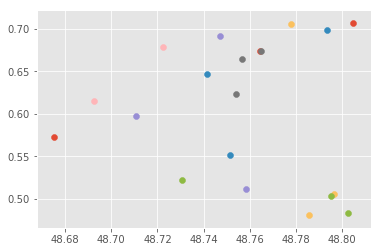

In [201]:
min_test_fun = 100
for n_b1 in [-2,-1,0,1,2]:
    for n_b2 in [0,0.01,0.1,1]:
        b1 = np.random.normal(0,1,(1,n_items))
        b2 = np.random.normal(0,1,(1,n_items))
#         print "1: ",(absm(b1,real_b1)+absm(b2,real_b2))/2
        
        min_fun = 100
        for n1 in [-2,-1,0,1,2]:
            for n2 in [0,0.01,0.1,1]:
                for w in [0.01]:
                    a = np.random.normal(n1, n2, 2*uv.shape[1])
                    min_t1,min_t2,cost = min_thete(uv,w,b1,b2,a)
                    if cost < min_fun:
                        t1 = min_t1
                        t2 = min_t2
                        min_fun = cost
#         print "2: ",(absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4
        
        for i in range(10):
            b1,b2 = min_fun_b(uv, t1, t2, b1, b2)
            t1,t2 = min_fun_t(uv, t1, t2, b1, b2)
#         print "3: ",(absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4
        
        test_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1))).reshape(uv.shape)
        test_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2))).reshape(uv.shape)
        test_fun = -(uv*(np.log(test_p1)+np.log(test_p2))+(1-uv)*np.log(1-test_p1*test_p2)).sum()/uv.shape[1]+w*((t1**2).sum())+w*((t2**2).sum())+w*((b1**2).sum())+w*((b2**2).sum())
        if test_fun < min_test_fun:
            min_test_fun = test_fun
            min_test_t1 = t1
            min_test_t2 = t2
            min_test_b1 = b1
            min_test_b2 = b2
        print test_fun, (absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4
        plt.scatter(test_fun, (absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4)  

In [203]:
print min_test_fun,(absm(min_test_b1,real_b1)+absm(min_test_b2,real_b2)+absm(min_test_t1,real_t1)+absm(min_test_t2,real_t2))/4

48.674970402 0.5720308697


48.7074020617 0.632094316045
48.73751781 0.589818251036
48.8018180324 0.487083303748
48.7357006734 0.604350830806
48.7703070148 0.663090946902
48.6145008692 0.571612517928
48.7985643703 0.479699085809
48.736314119 0.595520037372
48.758464137 0.550474045472
48.8075140494 0.48467390775
48.7429157502 0.488483396993
48.7671668959 0.511434395446
48.7743284301 0.641406236061
48.719196865 0.526102485023
48.708719307 0.497988977614
48.6826408652 0.558135079319
48.7514222251 0.611006443527
48.7824252458 0.499232971315
48.8010186171 0.490655094652
48.7312234501 0.63355165764
48.7505094644 0.682488891538
48.8033548147 0.693346840712
48.8102435998 0.484100598228
48.7968015627 0.701145140902
48.7179243875 0.494094380274
48.7480652989 0.65665604986
48.7182731436 0.578610093013
48.7358964098 0.670422982835
48.8025370992 0.491788297262
48.717649191 0.645523038497
48.8030195448 0.702364761397
48.7505274192 0.478794582304
48.7854668267 0.49458811353
48.7829985963 0.497824606264
48.7637749145 0.623362571

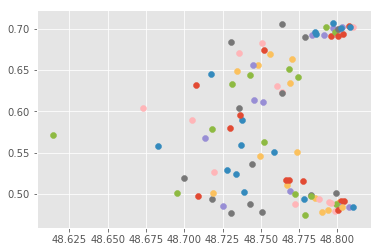

In [207]:
min_test_fun = 100
for n_b1 in range(100):
        b1 = np.random.normal(0,1,(1,n_items))
        b2 = np.random.normal(0,1,(1,n_items))
        
        min_fun = 100
        for n1 in [-2,-1,0,1,2]:
            for n2 in [0,0.01,0.1,1]:
                for w in [0.01]:
                    a = np.random.normal(n1, n2, 2*uv.shape[1])
                    min_t1,min_t2,cost = min_thete(uv,w,b1,b2,a)
                    if cost < min_fun:
                        t1 = min_t1
                        t2 = min_t2
                        min_fun = cost
        
        for i in range(10):
            b1,b2 = min_fun_b(uv, t1, t2, b1, b2)
            t1,t2 = min_fun_t(uv, t1, t2, b1, b2)
        
        test_p1 = 1.0/ (1.0 + np.exp(-(real_t1-real_b1))).reshape(uv.shape)
        test_p2 = 1.0/ (1.0 + np.exp(-(real_t2-real_b2))).reshape(uv.shape)
        test_fun = -(uv*(np.log(test_p1)+np.log(test_p2))+(1-uv)*np.log(1-test_p1*test_p2)).sum()/uv.shape[1]+w*((t1**2).sum())+w*((t2**2).sum())+w*((b1**2).sum())+w*((b2**2).sum())
        if test_fun < min_test_fun:
            min_test_fun = test_fun
            min_test_t1 = t1
            min_test_t2 = t2
            min_test_b1 = b1
            min_test_b2 = b2
        print test_fun, (absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4
        plt.scatter(test_fun, (absm(b1,real_b1)+absm(b2,real_b2)+absm(t1,real_t1)+absm(t2,real_t2))/4)  

array([ 0.8518,  0.0439])

array([-2.3287,  0.775 ])